# Практическое занятие 8
## Вариант 11

### Метод независимой оптимизации целевых функций

In [46]:
from scipy.optimize import linprog
import numpy as np

# Целевые функции
c1 = [5, -3]  # Z1 = 5x - 3y -> min
c2 = [6, 2]   # Z2 = 6x + 2y -> min
c3 = [-1, 3]  # Z3 = x - 3y -> max, переведем в минимизацию: -x + 3y -> min

# Ограничения
A = [[4, -1], [-1, 1], [2, -3]]
b = [0, 3, 6]

# Границы переменных
x_bounds = (0, None)
y_bounds = (0, None)

# Решение для каждой целевой функции
solution1 = linprog(c1, A_ub=A, b_ub=b, bounds=[x_bounds, y_bounds])
solution2 = linprog(c2, A_ub=A, b_ub=b, bounds=[x_bounds, y_bounds])
solution3 = linprog(c3, A_ub=A, b_ub=b, bounds=[x_bounds, y_bounds])


print(f'x = {solution1.x[0]}, y = {solution1.x[1]}, значение функции: {solution1.fun}')
print(f'x = {solution2.x[0]}, y = {solution2.x[1]}, значение функции: {solution2.fun}')
print(f'x = {solution3.x[0]}, y = {solution3.x[1]}, значение функции: {solution3.fun}')


x = 0.0, y = 3.0, значение функции: -9.0
x = 0.0, y = 0.0, значение функции: 0.0
x = -0.0, y = 0.0, значение функции: 0.0


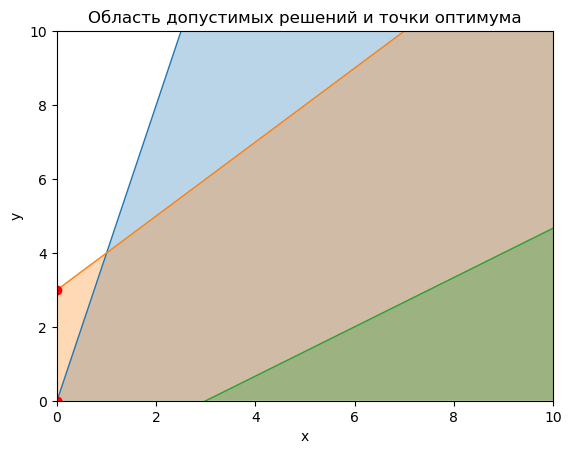

In [36]:
import matplotlib.pyplot as plt


# Функция для отрисовки области допустимых решений
def plot_feasible_region(ax, A, b):
	x = np.linspace(0, 10, 400)
	for i in range(len(A)):
		y = (b[i] - A[i][0] * x) / A[i][1]
		ax.plot(x, y, lw=1)
		ax.fill_between(x, 0, y, alpha=0.3)

# Функция для отрисовки точек оптимума
def plot_solutions(ax, solutions):
	for sol in solutions:
		if sol.success:
			ax.plot(sol.x[0], sol.x[1], 'ro')  # Точки оптимума

# Создание графика
fig, ax = plt.subplots()
plot_feasible_region(ax, A, b)
plot_solutions(ax, [solution1, solution2, solution3])

# Настройка графика
ax.set_xlim((0, 10))
ax.set_ylim((0, 10))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Область допустимых решений и точки оптимума')

plt.show()



1. **Оптимизация Z1 = 5x - 3y → min**
   - Оптимальное решение: x = `0`, y = `3`
   - Минимальное значение функции: **`-9`**

2. **Оптимизация Z2 = 6x + 2y → min**
   - Оптимальное решение: x = `0`, y = `0`
   - Минимальное значение функции: **`0`**

3. **Оптимизация Z3 = x - 3y → max** (преобразовано в -x + 3y → min)
   - Оптимальное решение: x = `0`, y = `0`
   - Минимальное значение функции: **`0`**


### Метод обобщенного критерия

In [40]:
# Весовые коэффициенты для целевых функций
w1, w2 = 0.3, 0.3
w3 = 1 - w1 - w2

# Обновленная объединенная целевая функция с учетом новых весов
combined_c = np.array(c1) * w1 + np.array(c2) * w2 - np.array(c3) * w3

# Решение обновленной объединенной задачи оптимизации
combined_solution = linprog(combined_c, A_ub=A, b_ub=b, bounds=[x_bounds, y_bounds], method='highs')

print(combined_solution.fun)



-4.5


При использовании **метода обобщенного критерия** с заданными весовыми коэффициентами:

-  w1 = `0.3`
-  w2 = `0.3`
-  w3 = `0.4`

Оптимальное решение находится в точке:

- x = `0`
- y = `3`

Значение обобщенной целевой функции в этой точке равно **-4.5**.


### Метод минимизации общей относительной уступки.

In [47]:
from scipy.optimize import minimize
import numpy as np

# Определение функций для оптимизации
def Z1(x):
	return 5 * x[0] - 3 * x[1]

def Z2(x):
	return 6 * x[0] + 2 * x[1]

def Z3(x):
	return -(x[0] - 3 * x[1])  # Минус для максимизации

# Ограничения
constraints = [
	{'type': 'ineq', 'fun': lambda x: 4 * x[0] - x[1]},   # 4x - y >= 0
	{'type': 'ineq', 'fun': lambda x: -x[0] + x[1] + 3},  # -x + y <= 3
	{'type': 'ineq', 'fun': lambda x: 2 * x[0] - 3 * x[1] + 6}, # 2x - 3y <= 6
	{'type': 'ineq', 'fun': lambda x: x[0]},             # x >= 0
	{'type': 'ineq', 'fun': lambda x: x[1]}              # y >= 0
]

# Начальная точка
x0 = np.array([1, 1])

# Оптимизация для Z1, Z2 и Z3
result_Z1 = minimize(Z1, x0, method='SLSQP', constraints=constraints)
result_Z2 = minimize(Z2, x0, method='SLSQP', constraints=constraints)
result_Z3 = minimize(Z3, x0, method='SLSQP', constraints=constraints)

m1, m2, m3 = result_Z1.fun, result_Z2.fun, -result_Z3.fun  # Минус для m3, так как это максимизация
m1, m2, m3, result_Z1.x, result_Z2.x, result_Z3.x  # Выводим найденные значения m1


(-4.199999999999866,
 -4.263256414560601e-14,
 2.9999999999999205,
 array([0.6, 2.4]),
 array([-7.10542736e-15,  0.00000000e+00]),
 array([3.00000000e+00, 2.08551062e-14]))

In [48]:
# Используем найденные значения m1, m2, m3 и коэффициенты k1, k2, k3
k1, k2, k3 = m1, m2, m3

# Функция для минимизации l
def objective_l(l):
	return l

# Ограничения для l
def constraint1_l(l):
	x = result_Z1.x
	return 5 * x[0] - 3 * x[1] - (m1 - k1 * l)

def constraint2_l(l):
	x = result_Z2.x
	return 6 * x[0] + 2 * x[1] - (m2 - k2 * l)

def constraint3_l(l):
	x = result_Z3.x
	return -(x[0] - 3 * x[1]) - (m3 - k3 * l)

# Определение ограничений для l
constraints_l = [
	{'type': 'ineq', 'fun': constraint1_l},
	{'type': 'ineq', 'fun': constraint2_l},
	{'type': 'ineq', 'fun': constraint3_l}
]

# Начальная точка для l
l0 = [0]

# Решение задачи минимизации для l
result_l = minimize(objective_l, l0, method='SLSQP', constraints=constraints_l)

result_l.fun, result_l.x # Выводим найденное значение l и точку оптимизации


(-9.265629964170612e-17, array([-9.26562996e-17]))

#### Результаты

##### Найденные значения для Z1, Z2, Z3

- **m1** (для Z1): `-4.20`
- **m2** (для Z2): `-4.26e-14`
- **m3** (для Z3): `3.00`

##### Оптимальные точки

- **Точка для Z1**: (`0.6`, `2.4`)
- **Точка для Z2**: (`-7.11e-15`, `0.00`)
- **Точка для Z3**: (`3.00`, `2.09e-14`)

##### Результат минимизации общей дополнительной уступки l

- **Минимальное значение l**: `-9.27e-17`
- **Точка оптимизации l**: (`-9.27e-17`)

### Метод последовательных уступок

In [73]:
from scipy.optimize import minimize
import numpy as np

# Задаем функции Z1, Z2, Z3
def Z1(x):
	return 5*x[0] - 3 * x[1]

def Z2(x):
	return 6*x[0] + 2 * x[1]

def Z3(x):
	return -(x[0] - 3 * x[1]) # минимизируем, поэтому используем отрицательное значение

# Ограничения
constraints = [
	{'type': 'ineq', 'fun': lambda x: 4 * x[0] - x[1]}, # 4x - y >= 0
	{'type': 'ineq', 'fun': lambda x: -x[0] + x[1] + 3}, # -x + y <= 3
	{'type': 'ineq', 'fun': lambda x: 2 * x[0] - 3 * x[1] + 6} # 2x - 3y <= 6
]

# Начальное приближение
x0 = np.array([0.5, 0.5])

# Находим максимум Z1
res_Z1 = minimize(Z1, x0, method='SLSQP', constraints=constraints)
m1 = res_Z1.fun
delta1 = 0.1 # примерный допустимый уступок для Z1

# Ограничения для Z2
constraints_Z2 = constraints + [{'type': 'ineq', 'fun': lambda x: Z1(x) - (m1 - delta1)}]

# Находим максимум Z2
res_Z2 = minimize(Z2, x0, method='SLSQP', constraints=constraints_Z2)
m2 = res_Z2.fun
delta2 = 0.5 # примерный допустимый уступок для Z2

# Ограничения для Z3
constraints_Z3 = constraints + [
	{'type': 'ineq', 'fun': lambda x: Z1(x) - (m1 - delta1)},
	{'type': 'ineq', 'fun': lambda x: Z2(x) - (m2 - delta2)}
]

# Находим максимум Z3
res_Z3 = minimize(Z3, x0, method='SLSQP', constraints=constraints_Z3)

res_Z3.x, -res_Z3.fun # Возвращаем оптимизированные значения x, y и максимум Z3

(array([-1., -4.]), 11.000000000001423)